## Designing Smart and Healthy Systems, Heinz College, CMU
### HW 3: Evaluation of the Intervention - Task 2

#### Group 4: Batshur (Shuree) Gootiz, Sanjana Kotecha

In [1]:
# Imports required to load the datasets from S3 Bucket
import os
import boto3
from boto3 import client
import botocore

# Additional imports required for the homework tasks
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
# Function to read the data from csv file
def read_data_from_csv(filename,bucketname):
    dataframe = pd.read_csv('s3://{}/{}'.format(bucketname, filename), encoding = 'ISO-8859-1')
    return dataframe.copy()

# Function to read the data from excel sheet
def read_data_from_excel(filename,sheetname,bucketname):
    dataframe = pd.read_excel('s3://{}/{}'.format(bucketname, filename), sheetname, encoding = 'ISO-8859-1')
    return dataframe.copy()

# Function to display basic data info
def display_basic_data(dataframe):
    #Get the first 5 rows of the CSV
    display(dataframe.head(5))
    dataframe.info()

In [3]:
bucketname = "group4bucketapr20"
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(bucketname)
for my_bucket_object in my_bucket.objects.all():
    print(my_bucket_object)

s3.ObjectSummary(bucket_name='group4bucketapr20', key='consolidated_numerical.csv')
s3.ObjectSummary(bucket_name='group4bucketapr20', key='consolidated_numerical2.csv')
s3.ObjectSummary(bucket_name='group4bucketapr20', key='high_engagement_cluster.csv')
s3.ObjectSummary(bucket_name='group4bucketapr20', key='low_engagement_cluster.csv')
s3.ObjectSummary(bucket_name='group4bucketapr20', key='medium_engagement_cluster.csv')
s3.ObjectSummary(bucket_name='group4bucketapr20', key='outcome_var.csv')
s3.ObjectSummary(bucket_name='group4bucketapr20', key='outcome_var2.csv')
s3.ObjectSummary(bucket_name='group4bucketapr20', key='task2_dataset.csv')


In [4]:
task2_df = read_data_from_csv('task2_dataset.csv', bucketname)
task2_df.shape
#task2_df.columns


(11861, 25)

In [5]:
#Slicing for picking the essential columns for the analysis: Colesterol had some outliers; so remove for now
final_list=['IdPaciente', 'Edad', 'Sexo_x', 'IMC', 'Tabaco', 'Refrescos', 'ActividadFisica','Q1', 'Q2', 'Q3', 'Q4','Nutri_Q2', 'level', 'HBA1C']
analysis_df=task2_df[final_list]
analysis_df.shape
#analysis_df.columns

analysis_df.level.value_counts()

low       4676
medium    4026
high      3159
Name: level, dtype: int64

In [6]:
#First, slice the moderate and high engaged patients out of df: Our focus of analysis
analysis_df= analysis_df.loc[(analysis_df['level'] =='high') | (analysis_df['level']=='medium')]
analysis_df.shape

analysis_df.groupby(['level', 'Nutri_Q2']).count()

IdPaciente  Edad  Sexo_x   IMC  Tabaco  Refrescos  \
level  Nutri_Q2                                                      
high   0                187   187     187   187     187        187   
       1                649   649     645   649     649        649   
       2               1067  1067    1061  1067    1067       1067   
       3               1250  1250    1245  1250    1250       1250   
       4                  6     6       6     6       6          6   
medium 0               1478  1478    1468  1478    1478       1478   
       1               1584  1584    1573  1584    1584       1584   
       2                731   731     730   731     731        731   
       3                232   232     230   232     232        232   
       4                  1     1       1     1       1          1   

                 ActividadFisica    Q1    Q2    Q3    Q4  HBA1C  
level  Nutri_Q2                                                  
high   0                     187   187   187   187   187    187  
       1                     649   649   649   649   649    649  
       2                    1067  1067  1067  1067  1067   1067  
       3                    1250  1250  1250  1250  1250   1250  
       4                       6     6     6     6     6      6  
medium 0                    1478  1478  1478  1478  1478   1478  
       1                    1584  1584  1584  1584  1584   1584  
       2                     731   731   731   731   731    731  
       3                     232   232   232   232   232    232  
       4                       1     1     1     1     1      1

There are several ways to select the treatment variable; based on the graph (nutritional visit by Q), we decided to take the differene beteen number =>2 and less than 2. If we take no visit or 1 visit, there is not enough data for high engaged patients cluster (only 187 here). 

In [7]:
#Create treated variable: 1 if had 2 or more engagement in q2, 0 if less than 2 engagements in q2
analysis_df['treated'] = (analysis_df.Nutri_Q2.isin(range(2, 4))).astype(int)


There are 842 patients in high that have less than 2 visits, 2317 patients who have 2 or more visits. 
For medium, 3063 patients had less than 2 visits, and 963 patients had equal to 2 or more visits. 

In [8]:
#Our target variable =Y var is Q4 engagement level
analysis_df.rename(columns ={'Q4' :'target', 'Sexo_x': 'gender'}, inplace=True)
analysis_df.groupby(['level', 'treated']).count()

IdPaciente  Edad  gender   IMC  Tabaco  Refrescos  \
level  treated                                                      
high   0               842   842     838   842     842        842   
       1              2317  2317    2306  2317    2317       2317   
medium 0              3063  3063    3042  3063    3063       3063   
       1               963   963     960   963     963        963   

                ActividadFisica    Q1    Q2    Q3  target  Nutri_Q2  HBA1C  
level  treated                                                              
high   0                    842   842   842   842     842       842    842  
       1                   2317  2317  2317  2317    2317      2317   2317  
medium 0                   3063  3063  3063  3063    3063      3063   3063  
       1                    963   963   963   963     963       963    963

In [9]:
#Add another target variable that is binary one for logit model: 
#analysis_df['target'] = (analysis_df.level.is('high')).astype(int)

analysis_df['target1']= np.where((analysis_df['level']=='high'),1,0)


In [10]:
analysis_df.target1.value_counts()

0    4026
1    3159
Name: target1, dtype: int64

In [11]:
#Drop two more: no longer needed: take gender out for now, because it is having problem in the model fitting. 
final_list=['IdPaciente', 'Edad', 'gender', 'IMC', 'Tabaco', 'Refrescos', 'ActividadFisica','target', 'target1','HBA1C', 'treated']
clean_df=analysis_df[final_list]

In [12]:
#make gender a dummy variable
male = pd.get_dummies(clean_df['gender'],drop_first=True)
print(male.dtypes)

M    uint8
dtype: object


In [13]:
clean_df = pd.concat([clean_df, male],axis=1)
clean_df.head()

,IdPaciente,Edad,gender,IMC,Tabaco,Refrescos,ActividadFisica,target,target1,HBA1C,treated,M
3,6,57,H,26.472,0,1,0,10.0,1,6.5,0,0
8,14,46,M,36.766,0,1,0,2.0,0,12.0,0,1
9,15,56,M,30.823,0,1,1,10.0,1,12.0,0,1
12,23,62,M,26.400,0,1,0,10.0,1,11.0,0,1
14,28,36,M,28.464,0,1,1,4.5,0,11.0,0,1


In [14]:
clean_df.Refrescos.value_counts()

1    5638
0    1547
Name: Refrescos, dtype: int64

In [15]:
#Clean up some variables and re-code the values
clean_df['Tabaco'] = clean_df['Tabaco'].map({0: 0, 1: 0, 2:1})


In [16]:
clean_df['Tabaco'].value_counts()

0    6209
1     976
Name: Tabaco, dtype: int64

In [17]:
#Drop gender, since we have a dummy variable
clean_df.drop(['gender'], axis=1, inplace=True)


(7185, 11)

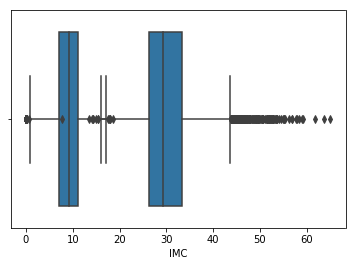

In [18]:
#Both HBA1AC and Colestrol are highly skewed: 
sns.boxplot(clean_df['HBA1C'])
sns.boxplot(clean_df['IMC'])
clean_df.shape

In [19]:
clean_df.loc[clean_df['HBA1C'] >15].count()  #Too high values of 72 rows outliers
clean_df.loc[clean_df['HBA1C'] < 4].count()  #Too low values 0, 1, 2, 3 are outliers

IdPaciente         137
Edad               137
IMC                137
Tabaco             137
Refrescos          137
ActividadFisica    137
target             137
target1            137
HBA1C              137
treated            137
M                  137
dtype: int64

(6970, 11)

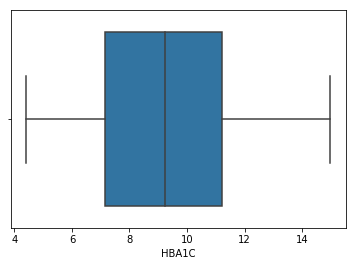

In [20]:
#removing outliers
clean_df=clean_df.loc[clean_df['HBA1C'] <15]  #keep these
clean_df=clean_df.loc[clean_df['HBA1C'] > 4]  #keep these
sns.boxplot(clean_df['HBA1C'])
clean_df.shape

In [21]:
clean_df.describe()

,IdPaciente,Edad,IMC,Tabaco,Refrescos,ActividadFisica,target,target1,HBA1C,treated,M
count,6970.000000,6970.000000,6970.000000,6970.000000,6970.000000,6970.000000,6970.000000,6970.000000,6970.000000,6970.000000,6970.000000
mean,7776.543472,53.441463,30.200477,0.137446,0.785653,0.277762,4.959924,0.438737,9.274406,0.456958,0.574892
std,3548.090582,12.041390,5.752874,0.344342,0.410398,0.447927,3.621622,0.496268,2.402878,0.498180,0.494395
min,6.000000,10.000000,0.201000,0.000000,0.000000,0.000000,2.000000,0.000000,4.400000,0.000000,0.000000
25%,5144.250000,46.000000,26.354250,0.000000,1.000000,0.000000,2.000000,0.000000,7.162500,0.000000,0.000000
50%,7946.500000,54.000000,29.344500,0.000000,1.000000,0.000000,2.000000,0.000000,9.240000,0.000000,1.000000
75%,10703.250000,62.000000,33.298000,0.000000,1.000000,1.000000,9.330000,1.000000,11.200000,1.000000,1.000000
max,13973.000000,88.000000,65.029000,1.000000,1.000000,1.000000,12.000000,1.000000,14.980000,1.000000,1.000000


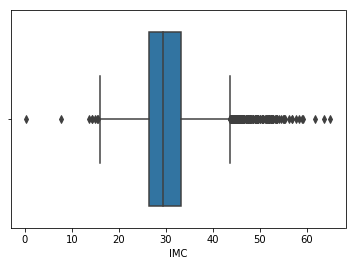

In [22]:
#IMC
sns.boxplot(clean_df['IMC'])  #Outliers:? <15 and >45

In [23]:
list_count=[]
list_count.append(clean_df.loc[clean_df['IMC'] > 45].count())  #Too high values of 72 rows outliers
list_count.append(clean_df.loc[clean_df['IMC'] < 17].count())
list_count

[IdPaciente         134
 Edad               134
 IMC                134
 Tabaco             134
 Refrescos          134
 ActividadFisica    134
 target             134
 target1            134
 HBA1C              134
 treated            134
 M                  134
 dtype: int64, IdPaciente         13
 Edad               13
 IMC                13
 Tabaco             13
 Refrescos          13
 ActividadFisica    13
 target             13
 target1            13
 HBA1C              13
 treated            13
 M                  13
 dtype: int64]

0    3840
1    2983
Name: target1, dtype: int64

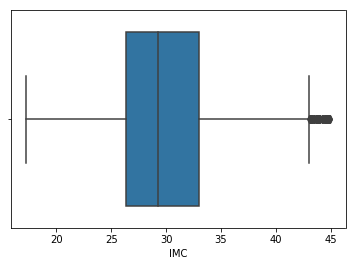

In [24]:
clean_df=clean_df.loc[clean_df['IMC'] <45]  #keep these
clean_df=clean_df.loc[clean_df['IMC'] > 17]  #keep these
sns.boxplot(clean_df['IMC'])
clean_df.shape
clean_df.target1.value_counts()

In [25]:
clean_df.dtypes

IdPaciente           int64
Edad                 int64
IMC                float64
Tabaco               int64
Refrescos            int64
ActividadFisica      int64
target             float64
target1              int64
HBA1C              float64
treated              int64
M                    uint8
dtype: object

In [26]:
#Convert multictegorical variables into such types: and target =y
y = clean_df.target # define the target variable (dependent variable) as y
y= y.astype(int)
y.dtype
clean_df.target.astype(int).head()

3     10
8      2
9     10
12    10
14     4
Name: target, dtype: int64

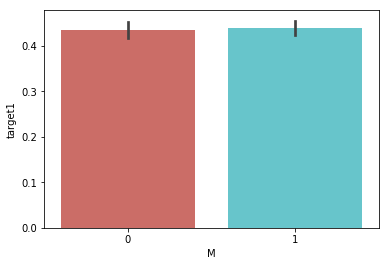

In [27]:
#Visualization on numbers of groups in treated group
#sns.countplot(x='treated', data=clean_df, palette='hls')
sns.barplot(x='treated', y ='ActividadFisica', data=clean_df, palette='hls')
#sns.barplot(x='treated', y ='target', data=clean_df, palette='hls')
#sns.barplot(x='M', y ='target1', data=clean_df, palette='hls')


The group that has been treated have higher physical activities on average. This means we cannot infer the difference in engagement solely to difference in nutritional visits. Patients in the nutrition appointments group have higher engagement than those in the control group. We should find out whether the difference in engagement is attributable to the nutrition visits. 

In [28]:
clean_df.target1.value_counts()

0    3840
1    2983
Name: target1, dtype: int64

In [29]:
print(clean_df.shape)
print(clean_df.columns)
print(clean_df.dtypes)
#clean_df.head()


(6823, 11)
Index(['IdPaciente', 'Edad', 'IMC', 'Tabaco', 'Refrescos', 'ActividadFisica',
       'target', 'target1', 'HBA1C', 'treated', 'M'],
      dtype='object')
IdPaciente           int64
Edad                 int64
IMC                float64
Tabaco               int64
Refrescos            int64
ActividadFisica      int64
target             float64
target1              int64
HBA1C              float64
treated              int64
M                    uint8
dtype: object


The difference between those in treated and control on average looks different, but we don't know if it is due to the treatment or not at this stage. 

In [30]:
mean_by_treat=clean_df.groupby('treated')['target'].mean()
print(mean_by_treat)
print(mean_by_treat[1] -mean_by_treat[0])

treated
0    3.777530
1    6.371464
Name: target, dtype: float64
2.5939342188422705


In [31]:
clean_df.groupby('treated')['M'].mean()

treated
0    0.551510
1    0.596469
Name: M, dtype: float64

In [32]:
#Compare the means of covariates
list_means=['']
list_col =['target', 'Edad', 'M', 'Tabaco', 'Refrescos', 'ActividadFisica', 'IMC', 'HBA1C']
for item in list_col:
    mean_by_treat=clean_df.groupby('treated')[item].mean()
    list_means.append(mean_by_treat)
print('Vars', '       ','Control', ' ', 'Treatment')
print('---------------------------------')
print('Outcome:      ', '{:0.2f} '        ' {:0.2f}'.format(list_means[1][0], list_means[1][1]))
print('Age:          ', '{:0.2f} '        ' {:0.2f}'.format(list_means[2][0], list_means[2][1]))
print('Male:         ', '{:0.2f} '        ' {:0.2f}'.format(list_means[3][0], list_means[3][1]))
print('Tabaco:       ', '{:0.2f} '        ' {:0.2f}'.format(list_means[4][0], list_means[4][1]))
print('Refrescos:    ', '{:0.2f} '        ' {:0.2f}'.format(list_means[5][0], list_means[5][1]))
print('PhysActivity: ', '{:0.2f} '        ' {:0.2f}'.format(list_means[6][0], list_means[6][1]))
print('IMC:          ', '{:0.2f} '      ' {:0.2f}'.format(list_means[7][0], list_means[7][1]))
print('HBA1C:        ', '{:0.2f} '        ' {:0.2f}'.format(list_means[8][0], list_means[8][1]))


Vars         Control   Treatment
---------------------------------
Outcome:       3.78  6.37
Age:           52.70  54.53
Male:          0.55  0.60
Tabaco:        0.15  0.12
Refrescos:     0.80  0.77
PhysActivity:  0.27  0.29
IMC:           29.95  29.73
HBA1C:         9.42  9.13


In [33]:
#clean_df.Edad.astype(float)
clean_df['Edad'] = clean_df['Edad'].astype(int)
clean_df['IMC'] = clean_df['IMC'].astype(int)
clean_df['target'] = clean_df['target'].astype(int)
clean_df['HBA1C'] = clean_df['HBA1C'].astype(int)
#clean_df['gender'] = clean_df['gender'].astype(float)
print(clean_df.dtypes)
clean_df.head()

IdPaciente         int64
Edad               int64
IMC                int64
Tabaco             int64
Refrescos          int64
ActividadFisica    int64
target             int64
target1            int64
HBA1C              int64
treated            int64
M                  uint8
dtype: object


,IdPaciente,Edad,IMC,Tabaco,Refrescos,ActividadFisica,target,target1,HBA1C,treated,M
3,6,57,26,0,1,0,10,1,6,0,0
8,14,46,36,0,1,0,2,0,12,0,1
9,15,56,30,0,1,1,10,1,12,0,1
12,23,62,26,0,1,0,10,1,11,0,1
14,28,36,28,0,1,1,4,0,11,0,1


In [34]:
#Step 1: Propensity Scoring
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def make_X(df):
    X=df.drop(['treated', 'target', 'IdPaciente', 'target1'], axis=1)
    X['Edad^2']= X['Edad'] * X['Edad']
    X['Edad^3']= X['Edad'] * X['Edad']* X['Edad']
    return X

X_variables=make_X(clean_df)
treat=clean_df['treated']
target=clean_df['target']

In [35]:
print(X_variables.head())


    Edad  IMC  Tabaco  Refrescos  ActividadFisica  HBA1C  M  Edad^2  Edad^3
3     57   26       0          1                0      6  0    3249  185193
8     46   36       0          1                0     12  1    2116   97336
9     56   30       0          1                1     12  1    3136  175616
12    62   26       0          1                0     11  1    3844  238328
14    36   28       0          1                1     11  1    1296   46656


In [36]:
logistic = LogisticRegression(solver='liblinear')
logistic.fit(X_variables, treat)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [37]:
pscore = logistic.predict_proba(X_variables)[:, 1]
pscore

array([0.48326213, 0.40496759, 0.45400682, ..., 0.44771469, 0.43651764,
       0.39559783])

In [38]:
roc_auc_score(treat, pscore)

0.5564788553143521

In [39]:
mask = treat == 1
pos_pscore = pscore[mask]
neg_pscore = pscore[~mask]
print('treatment count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

treatment count: (3115,)
control count: (3708,)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


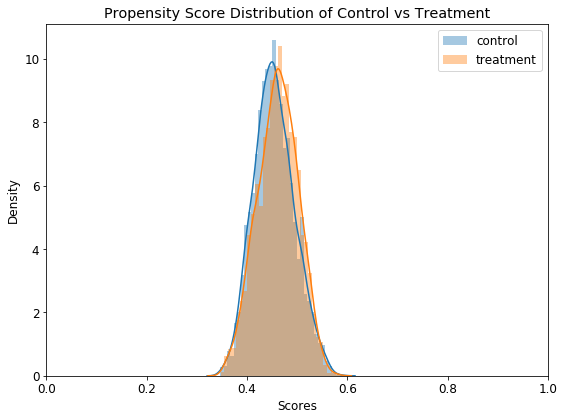

In [40]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(neg_pscore, label='control')
sns.distplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
pos_pscore

array([0.46392611, 0.45932177, 0.50799246, ..., 0.45572277, 0.48328074,
       0.41291424])

In [42]:
def get_similar(pos_pscore: np.ndarray, neg_pscore: np.ndarray, topn: int=5, n_jobs: int=1):
    from sklearn.neighbors import NearestNeighbors

    knn = NearestNeighbors(n_neighbors=topn + 1, metric='euclidean', n_jobs=n_jobs)
    knn.fit(neg_pscore.reshape(-1, 1))

    distances, indices = knn.kneighbors(pos_pscore.reshape(-1, 1))
    sim_distances = distances[:, 1:]
    sim_indices = indices[:, 1:]
    return sim_distances, sim_indices


sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=1)
sim_indices

array([[3043],
       [1663],
       [ 373],
       ...,
       [ 294],
       [3443],
       [3316]])

In [43]:
_, counts = np.unique(sim_indices[:, 0], return_counts=True)
np.bincount(counts)

array([   0, 1015,  461,  199,   73,   39,    8,    3,    2,    1])

In [44]:
df=clean_df
df['TREATMENT'] = treat
df['TARGET'] = target
df_pos = df[mask]
df_neg = df[~mask].iloc[sim_indices[:, 0]]
df_matched = pd.concat([df_pos, df_neg], axis=0)

In [45]:
print(clean_df.shape)
print(df_matched.shape)

(6823, 13)
(6230, 13)


Upon completing propensity score matching, we can carry out a outcome analysis using a paired t-test. The test result shows that the difference between the two groups are statistically significant, with large t value and small p value. Since the p-value is smaller than the threshold of 1%, we can reject the null hypothesis that the two groups have equal averages. 

In [48]:
#Having matched the pairs, let us do t-test on the two samples 
num_matched_pairs = df_neg.shape[0]
print('The number of matched pairs: ', num_matched_pairs)

# pair t-test
tstat, pvalue=stats.ttest_rel(df_pos['TARGET'].values, df_neg['TARGET'].values)
print('T-statistic: ','{:0.4f}'.format(tstat))
print('2-tailed p-value: ','{:0.4f}'.format(pvalue))

The number of matched pairs:  3115
T-statistic:  30.5017
2-tailed p-value:  0.0000


###References consulted: 

For matching: 
On github
http://ethen8181.github.io/machine-learning/ab_tests/causal_inference/matching.html

Youtube
Workers earnings evaluation
https://www.youtube.com/watch?v=h9mD43crH0I

https://medium.com/@bmiroglio/introducing-the-pymatch-package-6a8c020e2009
